# 2-Classifying Problem with Single qubit[Stochastic]

In [16]:
import pennylane as qml
from pennylane.optimize import GradientDescentOptimizer
from pennylane import numpy as np

import matplotlib.pyplot as plt

### Data Generation

In [51]:
# Setting a random seed for reproducing
np.random.seed(32)

# Making a traing dataset of points inside and outside of a circle
def Circle(samples, condition = [[0.0, 0.0], np.sqrt(2 / np.pi)]):
    """
    INPUT
    samples : the number of data points we will make
    center : center of the circle    
    radius : radius of the circle
    condition : conditions of the circle (condition[0] = center, condition[1] = radius)
    
    OUTPUT
    data points & labels(In - 1/Out - -1) for each point
    """
    points= []
    labels = []

    for i in range(samples):
        
        # Mading sample points
        point = 2*np.random.rand(2)-1
        label = 1

        # Changing label to 1 if it is out of the circle
        if np.linalg.norm(point - condition[0]) > condition[1]:
            label = -1
        
        # Collecting the sample points
        points.append(point)
        labels.append(label)

    return np.array(points, requires_grad = False), np.array(labels, requires_grad = False)

# ----------------------------------------------------------------------------------------------- #

def Sin(samples, condition = [1,]):
    """
    INPUT
    samples : the number of data points we will generate
    condition : condtion of the sin function (condition[0] = amplitude, condition[1] = frequency)

    OUTPUT
    data points & labels(Under - 1/Over - -1) for each point
    """

    points = []
    labels = []

    for i in range(samples):
        point = 2*np.random.rand(2)-1
        label = 1

        if point[1] > condition[0]*np.sin(np.pi*point[0]):
            label = -1

        points.append(point)
        labels.append(label)

    return np.array(points, requires_grad = False), np.array(labels, requires_grad = False)

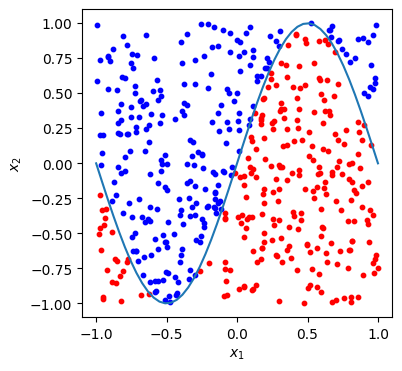

In [54]:
# Plotting the data with figuration
def plot_data(x, y, fig = None, ax = None, problem = ""):
    """
    Plotting the data with the binary classification

    data_points : data_points that will be plotted on the graph
    data_labels : which classify the points with different colors

    Return
    plot graph
    """
    # Graph figure
    if fig == None :
        fig, ax = plt.subplots(1,1,figsize = (5, 5))
    
    # Giving color for each point
    red = y == 1
    blue = y == -1
    if problem == None:
        print("Define the problem")
    
    if problem == "circle":
        draw_circle = plt.Circle((0.0, 0.0), np.sqrt(2 / np.pi), fill=False)
        ax.scatter(x[red,0],x[red,1], c = "red", s = 10)
        ax.scatter(x[blue,0],x[blue,1], c = "blue", s = 10)
        ax.add_artist(draw_circle)
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")

    if problem == "sin":
        x1 = np.linspace(-1, 1)
        x2 = np.sin(np.pi*x1)
        ax.scatter(x[red,0],x[red,1], c = "red", s = 10)
        ax.scatter(x[blue,0],x[blue,1], c = "blue", s = 10)
        ax.plot(x1, x2)
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
Xpoints, Ylabels = Sin(500)
plot_data(Xpoints, Ylabels, fig = fig, ax = ax, problem = "sin")

### Designing the Quantum Circuit Model

In [20]:
dev_stochastic = qml.device("lightning.qubit", wires=1, shots=1000)

@qml.qnode(dev_stochastic)
def SQC_orign(params, x):
    """
    Design the circuit model with the origin scheme

    INPUT
    params : parameters for the Uitary Gate U(p) (num_layers, 3)
    x : one data point (1, 3)
    y : label of the data point

    OUPUT
    expectation vlaue of the circuit
    """
    ### Origin scheme
    for p in params:
        qml.Rot(*p, wires = 0)
        qml.Rot(*x, wires = 0)
    
    return qml.expval(qml.PauliZ(0))

In [21]:
dev_stochastic = qml.device("lightning.qubit", wires=1, shots=1000)

@qml.qnode(dev_stochastic)
def SQC_comp(thetas, weights, x):
    """
    Variational Quantum Circuit for Universal Quantum Classifier
    Fig1.(b) Compressed Scheme

    theta : array of theta...bias (theta_1, theta_2, theta_3)
    weight : array of wegiht...weight (w_1, w_2, w_3)
    x : Datas where we have to input (x_1, x_2, 0)
    y : Expected ouput density matrix

    Returns
    Expectation value
    """
    params = []
    for i in range(len(thetas)):
        params.append(thetas[i]+weights[i]*x)

    # Compressed scheme
    for p in params:
        qml.Rot(*p, wires = 0)
    
    # Calculating the expectation value of the supplied observable
    return qml.expval(qml.PauliZ(0))

### Loss function

In [22]:
def loss_functionO(params, x, y):
    """
    loss function to be minimized

    INPUT
    params : parmeters that will be used
    x : data points for re-uploading
    
    OUTPUT
    loss value to be minimized
    """

    loss = 0.0

    for i in range(len(x)):
        f = SQC_orign(params, x[i])
        if y[i] == 1:
            loss += (1 - f)**2
        else:
            loss += (1 + f)**2
    return loss / len(x)

In [23]:
def loss_functionC(thetas, weights, x, y):
    """
    loss function to be minimized

    INPUT
    circuit : the circuit model of the classifier
    params : parmeters that will be used
    x : data points for re-uploading
    
    OUTPUT
    loss value to be minimized
    """

    loss = 0.0

    for i in range(len(x)):
        f = SQC_comp(thetas, weights, x[i])
        if y[i] == 1:
            loss += (1 - f)**2
        else:
            loss += (1 + f)**2
    return loss / len(x)

### Model Runnig

In [24]:
def model_runningO(params, x):
    """
    Model running with given set of data.

    INPUT
    params : array of parameters (num_layers, 3)
    x : array of data points (num_data, 3)
    y : array of true data labels (num_data, 1)
    state_labels : state representations for labels

    Returns
    Predicted labels for given data, Expectation value of the circuit
    """
    predicted = []
    exepctation_values = []
    for i in range(len(x)):
        expval = SQC_orign(params, x[i])
        exepctation_values.append(expval)
        
        if expval >= 0 :
            predicted.append(1)
        else:
            predicted.append(-1)
        
    return np.array(predicted), np.array(exepctation_values)

In [25]:
def model_runningC(thetas, weights, x):
    """
    Model running with given set of data.

    INPUT
    params : array of parameters (num_layers, 3)
    x : array of data points (num_data, 3)
    y : array of true data labels (num_data, 1)
    state_labels : state representations for labels

    Returns
    Predicted labels for given data, Expectation value of the circuit
    """
    predicted = []
    exepctation_values = []
    for i in range(len(x)):
        expval = SQC_comp(thetas, weights, x[i])
        exepctation_values.append(expval)
        
        if expval >= 0 :
            predicted.append(1)
        else:
            predicted.append(-1)
        
    return np.array(predicted), np.array(exepctation_values)

### Accuracy Score

In [26]:
def accuracy_score(y_true, y_pred):
    """
    Accuracy score. Evaluating the model with the label comparing.
    
    INPUT
    y_true : Targets(Answers)
    y_predicted : Predictions(labels wihch model has given)

    OUTPUT
    the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)

### Making batches for optimizing

In [27]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data
    
    INPUT
    inputs : input data
    targets : targets
    batch_size : size of the batch, the number of datas in one batch

    Returns
    one batch of input data of length `batch_size`, one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

## Process of Origin scheme SQC

In [41]:
### Origin scheme sinle-qubit classifier model

# the numbers of training and test data
num_training = 500
num_test = 4000

# Training datas(where we will train the data)
Xdata, y_train = Circle(num_training)
# for 2-dim points
train_data = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Testing datas(where we get the model accuracy)
Xtest, y_test = Circle(num_test)
# for 2-dim points
test_data = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Setting the training options
num_layers = 4
epochs = 50
batch_size = 50
eta = 0.1

# Using the Optimizer
opt = GradientDescentOptimizer(eta)

# Initializing random weights the parameters for U(p)
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

### Evaluating the classifier
# Running the model with test data
predicted_train, expvals_train = model_runningO(params, train_data)
accuracy_train = accuracy_score(y_train, predicted_train)

# Running the model with the test data
predicted_test, expvals_test = model_runningO(params, test_data)
accuracy_test = accuracy_score(y_test, predicted_test)

# Saving predictions with random weights for comparison 
initial_predictions = predicted_test

loss = loss_functionO(params, test_data, y_test)

loss_list, accuracy_train_list, accuracy_test_list = [], [], []
loss_list.append(loss)
accuracy_train_list.append(accuracy_train)
accuracy_test_list.append(accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, y_train, batch_size=batch_size):
        params, _, _ = opt.step(loss_functionO, params, Xbatch, ybatch)

    predicted_train, expvals_train = model_runningO(params, train_data)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = loss_functionO(params, train_data, y_train)

    predicted_test, expvals_test = model_runningO(params, test_data)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

Epoch:  0 | Cost: 1.568194 | Train accuracy: 0.458000 | Test Accuracy: 0.471500
Epoch:  1 | Loss: 1.046242 | Train accuracy: 0.606000 | Test accuracy: 0.626500
Epoch:  2 | Loss: 0.735515 | Train accuracy: 0.704000 | Test accuracy: 0.724000
Epoch:  3 | Loss: 0.566782 | Train accuracy: 0.808000 | Test accuracy: 0.814000
Epoch:  4 | Loss: 0.511722 | Train accuracy: 0.830000 | Test accuracy: 0.842000
Epoch:  5 | Loss: 0.484774 | Train accuracy: 0.848000 | Test accuracy: 0.848000
Epoch:  6 | Loss: 0.468218 | Train accuracy: 0.856000 | Test accuracy: 0.854500
Epoch:  7 | Loss: 0.461874 | Train accuracy: 0.858000 | Test accuracy: 0.859750
Epoch:  8 | Loss: 0.451335 | Train accuracy: 0.862000 | Test accuracy: 0.863000
Epoch:  9 | Loss: 0.447790 | Train accuracy: 0.854000 | Test accuracy: 0.866500
Epoch: 10 | Loss: 0.440765 | Train accuracy: 0.864000 | Test accuracy: 0.870750
Epoch: 11 | Loss: 0.436908 | Train accuracy: 0.860000 | Test accuracy: 0.875250
Epoch: 12 | Loss: 0.428981 | Train accur

### Classifying Results

Cost: 0.401232 | Train accuracy 0.894000 | Test Accuracy : 0.909750
Learned weights
Layer 0: prameters = [0.61148126 0.43319723 0.07074826]
Layer 1: prameters = [ 0.12406585  0.87893825 -0.14776827]
Layer 2: prameters = [ 0.21221208 -0.49980658  0.12124315]
Layer 3: prameters = [2.76296222 1.01306881 0.33946391]


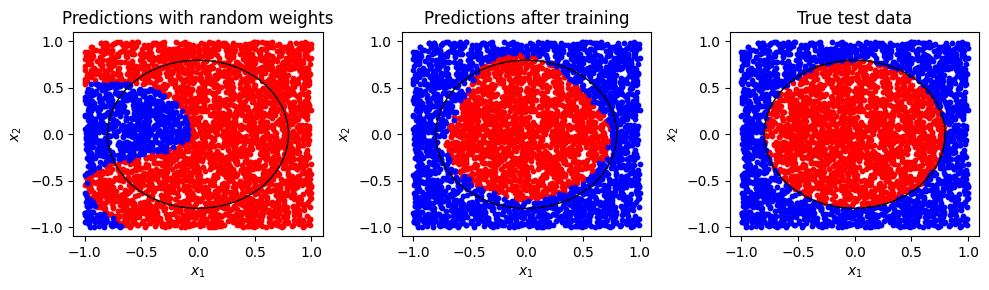

In [42]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: prameters = {}".format(i,params[i]))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data, initial_predictions, fig, axes[0], problem = "circle")
plot_data(test_data, predicted_test, fig, axes[1], problem = "circle")
plot_data(test_data, y_test, fig, axes[2], problem = "circle")

axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

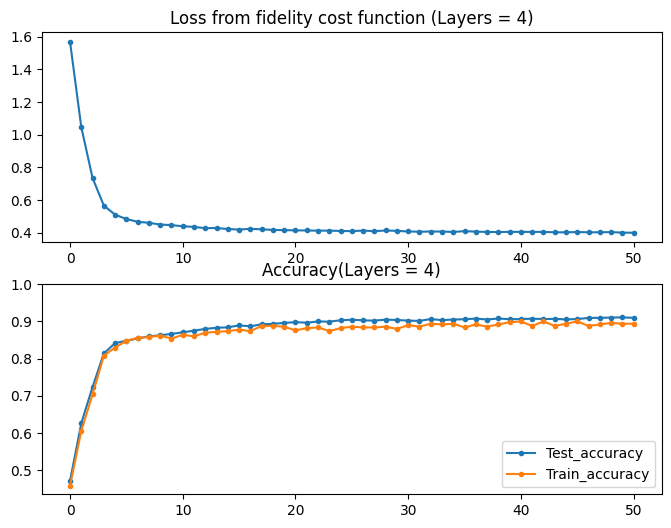

In [43]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test_accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train_accuracy')
axes[1].legend()
axes[1].set_ylim(top = 1.0)
axes[0].set_title(f"Loss from fidelity cost function (Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

## Process of Compressed scheme SQC

In [44]:
# the numbers of training and test data
num_class = 2
num_training = 500
num_test = 4000

# Training datas(where we will train the data)
Xdata, y_train = Circle(num_training)
train_data = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Testing datas(where we get the model accuracy)
Xtest, y_test = Circle(num_test)
test_data = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Setting the training options
num_layers = 6
epochs = 50
batch_size = 50
eta = 0.1

# Using the Optimizer
opt = GradientDescentOptimizer(eta)

# Initializing random weights the parameters for U(p)
thetas = np.random.uniform(size=(num_layers, 3), requires_grad=True)
weights = np.random.uniform(size=(num_layers, 3), requires_grad=True)
alphas = np.random.uniform(size= num_class , requires_grad=True)

### Evaluating the classifier
# Running the model with test data
predicted_train, expvals_train = model_runningC(thetas, weights, train_data)
accuracy_train = accuracy_score(y_train, predicted_train)

# Running the model with the test data
predicted_test, expvals_test = model_runningC(thetas, weights, test_data)
accuracy_test = accuracy_score(y_test, predicted_test)

# Saving predictions with random weights for comparison 
initial_predictions = predicted_test

loss = loss_functionC(thetas, weights, test_data, y_test)

loss_list, accuracy_train_list, accuracy_test_list = [], [], []
loss_list.append(loss)
accuracy_train_list.append(accuracy_train)
accuracy_test_list.append(accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, y_train, batch_size=batch_size):
        thetas, weights, _, _ = opt.step(loss_functionC, thetas, weights, Xbatch, ybatch)

    predicted_train, expvals_train = model_runningC(thetas, weights, train_data)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = loss_functionC(thetas, weights, train_data, y_train)

    predicted_test, expvals_test = model_runningC(thetas, weights, test_data)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )
    
    loss_list.append(loss)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

Epoch:  0 | Cost: 1.058449 | Train accuracy: 0.620000 | Test Accuracy: 0.623500
Epoch:  1 | Loss: 0.642321 | Train accuracy: 0.754000 | Test accuracy: 0.772250
Epoch:  2 | Loss: 0.459019 | Train accuracy: 0.924000 | Test accuracy: 0.927500
Epoch:  3 | Loss: 0.422876 | Train accuracy: 0.922000 | Test accuracy: 0.910000
Epoch:  4 | Loss: 0.413407 | Train accuracy: 0.922000 | Test accuracy: 0.903250
Epoch:  5 | Loss: 0.408050 | Train accuracy: 0.914000 | Test accuracy: 0.901000
Epoch:  6 | Loss: 0.406294 | Train accuracy: 0.910000 | Test accuracy: 0.902250
Epoch:  7 | Loss: 0.406166 | Train accuracy: 0.910000 | Test accuracy: 0.902750
Epoch:  8 | Loss: 0.402933 | Train accuracy: 0.902000 | Test accuracy: 0.901750
Epoch:  9 | Loss: 0.401568 | Train accuracy: 0.912000 | Test accuracy: 0.903750
Epoch: 10 | Loss: 0.399368 | Train accuracy: 0.912000 | Test accuracy: 0.904750
Epoch: 11 | Loss: 0.398106 | Train accuracy: 0.908000 | Test accuracy: 0.905000
Epoch: 12 | Loss: 0.399300 | Train accur

### Classifying Results

Cost: 0.398634 | Train accuracy 0.900000 | Test Accuracy : 0.906750
Learned weights
Layer 0: thetas = [0.12838719 1.47774137 0.09139157], weights = [0.83988793 0.59523012 0.59954782]
Layer 1: thetas = [-0.04360711  0.21202277  0.50143842], weights = [1.1692867  1.03798716 0.76710508]
Layer 2: thetas = [ 1.001446   -0.20124543  0.59106481], weights = [0.26926422 0.15490014 0.52740086]
Layer 3: thetas = [0.15546496 0.1785077  0.34655412], weights = [ 0.15728941 -0.28115723  0.37563675]
Layer 4: thetas = [0.45426841 0.62409382 0.03982811], weights = [0.68984506 0.23600288 0.72662592]
Layer 5: thetas = [0.23278424 0.93464626 0.01663458], weights = [-0.22929486 -0.60295933  0.66069808]
Class weight aplphas = [0.21315349 0.92307635]


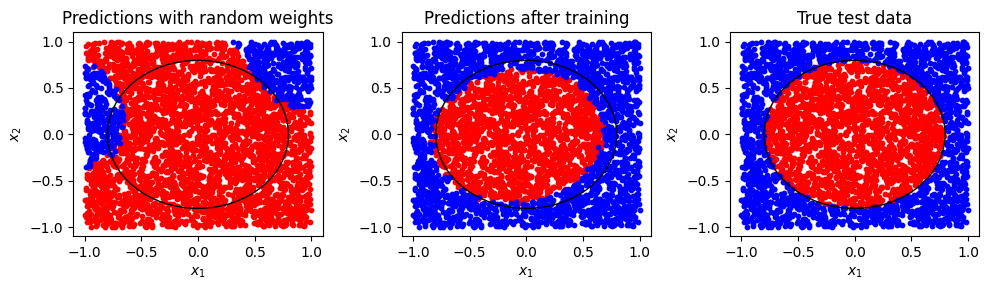

In [45]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: thetas = {}, weights = {}".format(i, thetas[i], weights[i]))

print("Class weight aplphas = {}".format(alphas))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data, initial_predictions, fig, axes[0])
plot_data(test_data, predicted_test, fig, axes[1])
plot_data(test_data, y_test, fig, axes[2])

axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

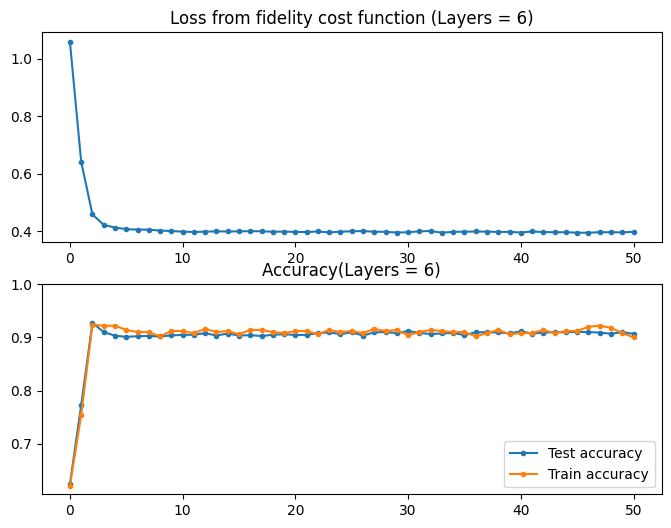

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(loss_list,'.-')
axes[1].plot(accuracy_test_list,'.-', label = 'Test accuracy')
axes[1].plot(accuracy_train_list,'.-', label = 'Train accuracy')
axes[1].set_ylim(top = 1.0)
axes[1].legend()
axes[0].set_title(f"Loss from fidelity cost function (Layers = {num_layers})")
axes[1].set_title(f"Accuracy(Layers = {num_layers})")
plt.show()

--------

In [55]:
### Origin scheme sinle-qubit classifier model

# the numbers of training and test data
num_training = 500
num_test = 4000

# Training datas(where we will train the data)
Xdata, y_train = Sin(num_training)
# for 2-dim points
train_data = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Testing datas(where we get the model accuracy)
Xtest, y_test = Sin(num_test)
# for 2-dim points
test_data = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False))) # point (x_1, x_2, x_3 = 0)

# Setting the training options
num_layers = 4
epochs = 50
batch_size = 50
eta = 0.1

# Using the Optimizer
opt = GradientDescentOptimizer(eta)

# Initializing random weights the parameters for U(p)
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)

### Evaluating the classifier
# Running the model with test data
predicted_train, expvals_train = model_runningO(params, train_data)
accuracy_train = accuracy_score(y_train, predicted_train)

# Running the model with the test data
predicted_test, expvals_test = model_runningO(params, test_data)
accuracy_test = accuracy_score(y_test, predicted_test)

# Saving predictions with random weights for comparison 
initial_predictions = predicted_test

loss = loss_functionO(params, test_data, y_test)

loss_list, accuracy_train_list, accuracy_test_list = [], [], []
loss_list.append(loss)
accuracy_train_list.append(accuracy_train)
accuracy_test_list.append(accuracy_test)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, y_train, batch_size=batch_size):
        params, _, _ = opt.step(loss_functionO, params, Xbatch, ybatch)

    predicted_train, expvals_train = model_runningO(params, train_data)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = loss_functionO(params, train_data, y_train)

    predicted_test, expvals_test = model_runningO(params, test_data)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(accuracy_train)
    accuracy_test_list.append(accuracy_test)

Epoch:  0 | Cost: 0.955731 | Train accuracy: 0.640000 | Test Accuracy: 0.654500
Epoch:  1 | Loss: 0.709844 | Train accuracy: 0.772000 | Test accuracy: 0.787750
Epoch:  2 | Loss: 0.582662 | Train accuracy: 0.816000 | Test accuracy: 0.840250
Epoch:  3 | Loss: 0.500665 | Train accuracy: 0.848000 | Test accuracy: 0.864000
Epoch:  4 | Loss: 0.464491 | Train accuracy: 0.858000 | Test accuracy: 0.868000
Epoch:  5 | Loss: 0.438729 | Train accuracy: 0.846000 | Test accuracy: 0.860750
Epoch:  6 | Loss: 0.421623 | Train accuracy: 0.856000 | Test accuracy: 0.862250
Epoch:  7 | Loss: 0.407441 | Train accuracy: 0.854000 | Test accuracy: 0.867250
Epoch:  8 | Loss: 0.397421 | Train accuracy: 0.860000 | Test accuracy: 0.874750
Epoch:  9 | Loss: 0.390145 | Train accuracy: 0.864000 | Test accuracy: 0.883500
Epoch: 10 | Loss: 0.386426 | Train accuracy: 0.868000 | Test accuracy: 0.887000
Epoch: 11 | Loss: 0.383435 | Train accuracy: 0.878000 | Test accuracy: 0.890750
Epoch: 12 | Loss: 0.381068 | Train accur

Cost: 0.349031 | Train accuracy 0.904000 | Test Accuracy : 0.908750
Learned weights
Layer 0: prameters = [0.15992879 1.07063758 0.54605591]
Layer 1: prameters = [-0.77643363  0.23991561 -0.4561604 ]
Layer 2: prameters = [-0.63337153  0.75714442  0.65908667]
Layer 3: prameters = [2.04586908 1.93922485 0.24760556]


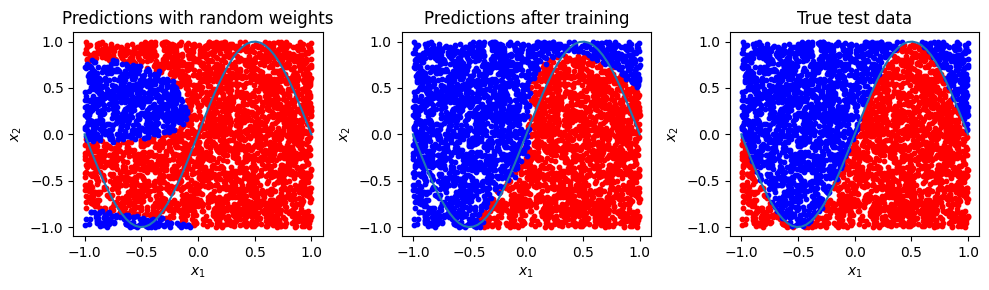

In [56]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: prameters = {}".format(i,params[i]))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(test_data, initial_predictions, fig, axes[0], problem = "sin")
plot_data(test_data, predicted_test, fig, axes[1], problem = "sin")
plot_data(test_data, y_test, fig, axes[2], problem = "sin")

axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()